In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

Text(0, 0.5, 'Inches')

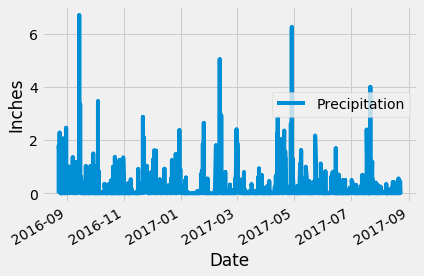

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Create query to retrieve all measurement dates
dates = session.query(Measurement.date).all()

# Create loop to format strings as parsed dates
parsed_dates = []

for date in dates:
    temp = str(date)
    temp = temp.replace('(', '')
    temp = temp.replace(')', '')
    temp = temp.replace(',', '')
    temp = temp.replace("'", '')
    parsed_date = dt.datetime.strptime(temp, '%Y-%m-%d')
    parsed_dates.append(parsed_date)

# Calculate date 1 year ago from the last data point in the database
max_date = max(parsed_dates)
min_date = max_date - timedelta(days=365)

# Create loop to filter dates to only 1 year ago
filtered_dates = []

for parsed_date in parsed_dates:
    if (parsed_date <= max_date) and (parsed_date >= min_date):
        filtered_dates.append(parsed_date)

# Create query to retrieve all precipitation scores
prcps = session.query(Measurement.prcp).all()

# Create loop to format strings as parsed prcps
parsed_prcps = []

for prcp in prcps:
    temp = str(prcp)
    temp = temp.replace('(', '')
    temp = temp.replace(')', '')
    temp = temp.replace(',', '')
    temp = temp.replace('None', '')
    parsed_prcps.append(temp)

# Create dataframe from parsed lists
measurement_df = pd.DataFrame({'Date': parsed_dates, 'Prcp': parsed_prcps})
measurement_df

# Filter dataframe to dates to only 1 year ago
date_filter = measurement_df['Date'] >= min_date
filtered_dates_df = measurement_df[date_filter]

# Filter dataframe to eliminate blank prcp entries
prcp_filter = filtered_dates_df['Prcp'] != ''
filtered_prcp_df = filtered_dates_df[prcp_filter]

# Separate columns before creating a new dataframe
final_dates = filtered_prcp_df['Date']
final_dates

# Convert prcp to float (user: SilentGhost)
# (url: https://stackoverflow.com/questions/1614236/in-python-how-do-i-convert-all-of-the-items-in-a-list-to-floats)
final_prcps = [float(i) for i in filtered_prcp_df['Prcp']]
final_prcps

# Create dataframe with filters applied
final_df = pd.DataFrame({'Date': final_dates, 'Precipitation': final_prcps})
final_df

# Use Pandas Plotting with Matplotlib to plot the data
graph = final_df.plot(x='Date', y='Precipitation')
graph.set_xlabel('Date')
graph.set_ylabel('Inches')

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data

# Find mean, median and mode and display results
mean = final_df['Precipitation'].mean()
print(f'The mean is: {mean}')

median = final_df['Precipitation'].median()
print(f'The median is: {median}')

mode = final_df['Precipitation'].mode()
print(f'The mode is: {mode}')

The mean is: 0.17727857496288968
The median is: 0.02
The mode is: 0    0.0
dtype: float64


In [12]:
# Design a query to show how many stations are available in this dataset?

# Join the two tables on station
sel = [Station.name, Measurement.station, Measurement.date, Measurement.tobs]
same_station = session.query(*sel).filter(Measurement.station == Station.station).all()

# Create a dataframe that includes station name
station_df = pd.DataFrame(same_station, columns=['Name', 'Station', 'Date', 'Tobs']).reset_index()

# Group the dataframe by station to get unique count
unique_stations = station_df.groupby('Station').nunique().rename_axis('Station Key').reset_index()

# Find unique count of stations
stations = len(unique_stations['Station Key'])

# Print finding
print(f'There are {stations} stations available in this dataset')

There are 9 stations available in this dataset


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

# Separate the two columns we are interested in
station = unique_stations['Station Key']
count = unique_stations['index']

# Create new dataframe to display data
station_count_df = pd.DataFrame({'Station': station, 'Row Count': count})

# Display data
station_count_df.sort_values(by='Row Count', ascending=False)

,Station,Row Count
6,USC00519281,2772
7,USC00519397,2724
1,USC00513117,2709
8,USC00519523,2669
3,USC00516128,2612
2,USC00514830,2202
0,USC00511918,1979
4,USC00517948,1372
5,USC00518838,511


In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

# Filter dataframe for station USC00519281
filter_station_df = station_df['Station'] == 'USC00519281'
active_station_df = station_df[filter_station_df]
active_station_df

# Calculate lowest temperature recorded
min_temp = active_station_df['Tobs'].min()

# Print results
print(f'The lowest temperature was: {min_temp}')

# Calculate highest temperature recorded
max_temp = active_station_df['Tobs'].max()

# Print results
print(f'The highest temperature was: {max_temp}')

# Calculate average temperature recorded
avg_temp = active_station_df['Tobs'].mean().round(1)

# Print results
print(f'The average temperature was: {avg_temp}')

The lowest temperature was: 54.0
The highest temperature was: 85.0
The average temperature was: 71.7


Text(0, 0.5, 'Frequency')

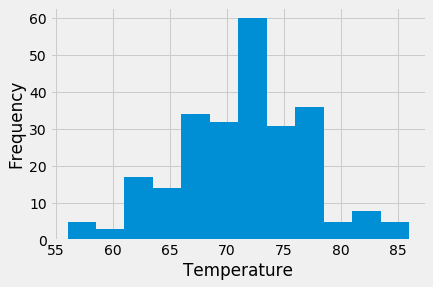

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Separate the two columns we are interested in
station = unique_stations['Station Key']
count = unique_stations['Tobs']

# Create new dataframe to display data
station_count_df = pd.DataFrame({'Station': station, 'Tobs Count': count})

# Display data
station_count_df.sort_values(by='Tobs Count', ascending=False)

# Filter dataframe for station USC00511918
filter_station_df = station_df['Station'] == 'USC00511918'
temp_station_df = station_df[filter_station_df]
temp_station_df

# Convert date column to datetime format
date = pd.to_datetime(temp_station_df['Date'])

# Pull out other columns from dataframe
name = temp_station_df['Name']
station = temp_station_df['Station']
tobs = temp_station_df['Tobs']

# Create new dataframe with formatted date
honolulu_df = pd.DataFrame({'Name': name, 'Station': station, 'Date': date, 'Temperature': tobs})
honolulu_df

# Find the latest date in the dataset
max_date = honolulu_df['Date'].max()

# Subtract a year from the latest date
min_date = max_date - pd.DateOffset(years=1)


# Filter for last 12 months
date_filter = honolulu_df['Date'] >= min_date
filtered_dates_df = honolulu_df[date_filter]
filtered_dates_df

# Plot the results as a histogram
filtered_dates_df.hist(bins=12)
plt.title('')
plt.xlabel('Temperature')
plt.ylabel('Frequency')

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
